<a href="https://colab.research.google.com/github/amysim0324-gif/Chaeeun/blob/main/%EC%88%98%EC%A0%95_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# (Colab 기준) 필요한 패키지 설치
!pip -q install statsmodels openpyxl prophet

# 한글 폰트 설치 (그래프 한글 깨짐 방지)
!apt-get -qq install fonts-nanum > /dev/null
!fc-list | grep -i nanum || echo "⚠️ Nanum 폰트 설치 실패"

import warnings, shutil, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
from IPython.display import display

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (12, 4)
rcParams['axes.unicode_minus'] = False

# NanumGothic 등록
cache_dir = mpl.get_cachedir()
shutil.rmtree(cache_dir, ignore_errors=True)
fm._load_fontmanager(try_read_cache=False)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'NanumGothic'
print("✅ 사용 폰트:", fm.findfont('NanumGothic', fallback_to_default=False))

/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Bold,나눔스퀘어라운드 Bold:style=Bold,Regular
/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf: NanumGothicCoding,나눔고딕코딩:style=Bold
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Regular,나눔스퀘어라운드 Regular:style=Regular
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf: NanumSquare,나눔스퀘어,NanumSquare Bold,나눔스퀘어 Bold:style=Bold
/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf: NanumBarunGothic,나눔바른고딕:style=Regular
/usr/share/fonts/truetype/nanum/NanumGothic.ttf: NanumGothic,나눔고딕:style=Regular
/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf: NanumGothicCoding,나눔고딕코딩:style=Regular
/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf: NanumBarunGothic,나눔바른고딕:style=Bold
/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf: NanumGothic,나눔고딕:style=Bold
/usr/share/fonts/truetype/nanum/NanumSquareR.ttf: NanumSquare,나눔스퀘어:style=Regular
/us

✅ 사용 폰트: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


# 패널 회귀모델 분석(민감도 추정) 단계

In [ ]:
# -*- coding: utf-8 -*-
# 개선 블록 1 — 정규화·다중공선성·견고성 보강 (per-model HAC(3) + 표준화계수 + FDR 보정)

import pandas as pd
import numpy as np
import statsmodels.api as sm
import patsy as pt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multitest import multipletests

# ====== 경로 ======
IN_PATH   = "/content/hmc_merged_preprocessed.csv"
OUT_PERM  = "/content/hmc_model_sensitivities_std.csv"
OUT_TWFE  = "/content/hmc_twfe_coeffs_std.csv"   # 참고용

# ====== 설정 ======
IV_VARS     = ["GSCPI", "krw_per_usd", "Brent_Oil"]
LAGS        = [1]                                 # 필요 시 [1,2,3]도 가능
MIN_OBS     = 60                                  # 모델별 최소 관측치(월)
MIN_STD_Y   = 1e-4                                # dlog_sales 분산 최소
R2_MAX_OK   = 0.9999                              # 과적합 제거
VIF_MAX     = 8.0                                 # 다중공선성 상한(>8이면 제거 시도)
USE_WINDOW  = 36                                  # 정규화 통계 산출용 최근 개월 수(없으면 전체)

# ====== 데이터 로드 ======
df = pd.read_csv(IN_PATH, parse_dates=["date"], low_memory=False)

# 필요 컬럼 점검
lag_cols = [f"{v}_lag{L}" for v in IV_VARS for L in LAGS]
need = ["Model", "dlog_sales", "date"] + lag_cols
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"필수 컬럼 누락: {miss}")

# ====== 정규화(스케일링) 통계: 최근 USE_WINDOW개월 기준 ======
cut_date = df["date"].max() - pd.DateOffset(months=USE_WINDOW)
stat_base = df.loc[df["date"] >= cut_date, :] if USE_WINDOW and (df["date"] >= cut_date).any() else df

# 각 lag 변수의 mean/std 계산 (전모델 공통 기준)
scaler_stats = (
    stat_base[lag_cols]
    .agg(["mean", "std"])
    .T.rename(columns={"mean":"mu", "std":"sd"})
)
# std=0 또는 NaN 방지
scaler_stats["sd"] = scaler_stats["sd"].replace(0, np.nan)

# 표준화 컬럼 생성: z_x = (x - mu)/sd
for col in lag_cols:
    mu = scaler_stats.loc[col, "mu"]
    sd = scaler_stats.loc[col, "sd"]
    if pd.notna(sd):
        df[f"z_{col}"] = (df[col] - mu) / sd
    else:
        df[f"z_{col}"] = np.nan  # 스케일 불가 시 결측 처리

# ====== 유틸: VIF 기반 컬럼 정리 ======
def reduce_multicol_by_vif(X, vif_max=VIF_MAX, min_vars=1):
    """X: (n,k) 독립변수 DataFrame. 높은 VIF 변수를 하나씩 제거."""
    keep = list(X.columns)
    while len(keep) > min_vars:
        _X = X[keep].dropna()
        if _X.shape[0] < 5 or _X.shape[1] < 2:
            break
        try:
            vifs = pd.Series(
                [variance_inflation_factor(_X.values, i) for i in range(_X.shape[1])],
                index=_X.columns
            )
        except Exception:
            break
        worst = vifs.idxmax()
        if vifs.max() <= vif_max or np.isinf(vifs.max()):
            break
        keep.remove(worst)
    return keep

# ====== per-model 회귀 (표준화 X로 적합, HAC(3)) ======
rows = []
for m, g in df.groupby("Model"):
    # 사용 컬럼 준비
    use_cols = [f"z_{c}" for c in lag_cols]  # 표준화된 IV
    g2 = g[["dlog_sales"] + use_cols + lag_cols].dropna().copy()
    if len(g2) < MIN_OBS:
        continue
    if g2["dlog_sales"].std() <= MIN_STD_Y:
        continue

    # 다중공선성 완화: VIF 기반 컬럼 축소
    iv_keep = reduce_multicol_by_vif(g2[use_cols], vif_max=VIF_MAX, min_vars=1)
    if len(iv_keep) == 0:
        continue

    Xz = sm.add_constant(g2[iv_keep])
    y  = g2["dlog_sales"]

    try:
        res = sm.OLS(y, Xz).fit(cov_type="HAC", cov_kwds={"maxlags":3})
    except Exception:
        res = sm.OLS(y, Xz).fit()

    r2 = float(res.rsquared) if res.rsquared is not None else np.nan
    if np.isnan(r2) or r2 >= R2_MAX_OK:
        continue

    # 표준화계수: X는 z-스케일(표준편차 1), β_std_full = β_z / sd_y
    sd_y = y.std(ddof=1)
    for zcol in iv_keep:
        var_raw = zcol.replace("z_", "")  # ex) GSCPI_lag1
        base  = var_raw.split("_lag")[0]  # ex) GSCPI
        beta_z = res.params.get(zcol, np.nan)
        se_z   = res.bse.get(zcol, np.nan)
        pval   = res.pvalues.get(zcol, np.nan)

        # 원단위 β 복원: β_raw = β_z / sd_X  (y는 원척도)
        sd_x = scaler_stats.loc[var_raw, "sd"]
        beta_raw = np.nan
        if pd.notna(sd_x) and sd_x != 0:
            beta_raw = beta_z / sd_x

        # 완전 표준화 β: β_std = β_z / sd_y  (X는 z, Y는 원척도 → std로 환산)
        beta_std = np.nan
        if pd.notna(sd_y) and sd_y != 0:
            beta_std = beta_z / sd_y

        rows.append({
            "Model": m,
            "variable": base,            # GSCPI / krw_per_usd / Brent_Oil
            "lag": var_raw.split("lag")[-1],  # '1' 등
            "beta_raw": float(beta_raw) if pd.notna(beta_raw) else np.nan,
            "beta_std": float(beta_std) if pd.notna(beta_std) else np.nan,
            "std_err_z": float(se_z) if pd.notna(se_z) else np.nan,
            "p_value": float(pval) if pd.notna(pval) else np.nan,
            "n_obs": int(res.nobs),
            "r2": r2
        })

per_model = pd.DataFrame(rows)
per_model = per_model.replace([np.inf, -np.inf], np.nan).dropna(subset=["p_value", "r2"])

# FDR(BH) 보정 — 변수 전체(모델×변수×lag) 공통 풀에서 보정
if not per_model.empty:
    try:
        rej, p_adj, *_ = multipletests(per_model["p_value"].values, method="fdr_bh")
        per_model["p_adj_bh"] = p_adj
        per_model["sig_bh_5pct"] = rej.astype(int)  # 1: 유의
    except Exception:
        per_model["p_adj_bh"] = np.nan
        per_model["sig_bh_5pct"] = np.nan

# ====== 참고용 TWFE(표준화 X, 날짜 FE 포함) ======
def run_twfe_std(data: pd.DataFrame) -> pd.DataFrame:
    # 표준화한 lag변수 사용
    z_terms = " + ".join([f"z_{c}" for c in lag_cols])
    data = data.dropna(subset=["dlog_sales"] + [f"z_{c}" for c in lag_cols]).copy()
    data["date_str"] = data["date"].dt.strftime("%Y-%m-01")
    formula = f"dlog_sales ~ {z_terms} + C(Model) + C(date_str)"
    y, X = pt.dmatrices(formula, data=data, return_type="dataframe")
    try:
        res = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": data["Model"]})
    except Exception:
        res = sm.OLS(y, X).fit()
    rows = []
    for c in [f"z_{v}_lag{L}" for v in IV_VARS for L in LAGS]:
        if c in res.params.index:
            rows.append({
                "spec": "TWFE_std_clusterModel",
                "variable": c.replace("z_","").split("_lag")[0],
                "lag": c.split("_lag")[-1],
                "beta_z": float(res.params[c]),
                "std_err_z": float(res.bse.get(c, np.nan)),
                "p_value": float(res.pvalues.get(c, np.nan)),
                "ci_low": float(res.conf_int().loc[c, 0]) if c in res.conf_int().index else np.nan,
                "ci_high": float(res.conf_int().loc[c, 1]) if c in res.conf_int().index else np.nan,
                "n_obs": float(res.nobs),
                "r2": float(res.rsquared)
            })
    return pd.DataFrame(rows)

twfe = run_twfe_std(df)

# ====== 저장 ======
per_model.to_csv(OUT_PERM, index=False, encoding="utf-8-sig")
twfe.to_csv(OUT_TWFE, index=False, encoding="utf-8-sig")

print("📈 per-model(표준화·HAC·FDR)  →", OUT_PERM, per_model.shape)
print("📊 TWFE(표준화, 참고용)       →", OUT_TWFE, twfe.shape)
print("✅ 끝")

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


📈 per-model(표준화·HAC·FDR)  → /content/hmc_model_sensitivities_std.csv (201, 11)
📊 TWFE(표준화, 참고용)       → /content/hmc_twfe_coeffs_std.csv (3, 10)
✅ 끝


/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


##결과 요약·해석(상위/하위 민감도, 유의성 필터)

In [ ]:
# -*- coding: utf-8 -*-
# 개선 블록 2 (p-value 고정 버전) — p<=0.05 기준, 표준화계수 우선, 원래 출력 형식 유지

import pandas as pd
import numpy as np

# ====== 경로 ======
PERM = "/content/hmc_model_sensitivities_std.csv"   # 개선 블록1 결과
TWFE = "/content/hmc_twfe_coeffs_std.csv"           # (선택) 참고용

# ====== 데이터 로드 ======
perm = pd.read_csv(PERM)
twfe = pd.read_csv(TWFE)

# 형 변환
for c in ["beta_std","beta_raw","p_value","r2","n_obs"]:
    if c in perm.columns:
        perm[c] = pd.to_numeric(perm[c], errors="coerce")

# ====== TWFE 결과 표시 ======
if not twfe.empty:
    print("=== 전체 평균 민감도 (TWFE, 표준화계수 기준) ===")
    twfe_disp = twfe.sort_values("p_value").reset_index(drop=True)
    display(twfe_disp)
else:
    print("⚠️ TWFE 결과가 없습니다. (블록1 실행 여부 확인 필요)")

# ====== 유의성 기준: p_value ≤ 0.05 (고정) ======
P_COL = "p_value"
ALPHA = 0.05
print(f"\n※ 유의성 기준: {P_COL} ≤ {ALPHA}")

# ====== 유의 모델 필터링 ======
sig = perm.query(f"{P_COL} <= @ALPHA").copy()

# 표준화계수 우선(없으면 원단위)
sig["abs_beta"] = np.where(sig["beta_std"].notna(), sig["beta_std"].abs(), sig["beta_raw"].abs())

# ====== 1) 변수별 유의 모델 수 ======
print("\n=== 모델별: 변수별 유의 모델 수 ===")
cnt_tbl = (
    sig.groupby("variable")["Model"]
       .nunique()
       .rename("n_models")
       .reset_index()
       .sort_values("n_models", ascending=False)
)
display(cnt_tbl)

# ====== 2) 절대 민감도 TOP 20 ======
print("\n=== 모델별: 절대 민감도 TOP 20 (표준화계수 우선, p≤0.05) ===")
top20 = sig.sort_values("abs_beta", ascending=False).head(20)[
    ["Model","variable","lag","beta_std","beta_raw",P_COL,"r2","n_obs"]
]
display(top20)

# ====== 3) 변수별 TOP 10 ======
print("\n=== 모델별: 변수별 상위 민감 모델 TOP 10 (p≤0.05) ===")
for var in ["GSCPI","krw_per_usd","Brent_Oil"]:
    tmp = sig[sig["variable"]==var].sort_values("abs_beta", ascending=False).head(10)
    if len(tmp)==0:
        continue
    print(f"\n## {var} TOP 10")
    display(tmp[["Model","lag","beta_std","beta_raw",P_COL,"r2","n_obs"]])

# ====== 4) 부호 일관성 점검 (안전한 agg 버전) ======
print("\n=== 변수별 부호 일관성 점검 (표준화계수 기준) ===")
beta_col = "beta_std" if sig["beta_std"].notna().any() else "beta_raw"

tmp = sig.copy()
tmp["valid"] = tmp[beta_col].notna()
tmp["pos"]   = tmp[beta_col] > 0
tmp["neg"]   = tmp[beta_col] < 0

sign_tbl = (
    tmp.groupby("variable")
       .agg(n_total_sig=("valid", "sum"),
            n_pos=("pos", "sum"),
            n_neg=("neg", "sum"))
       .reset_index()
)
sign_tbl["pos_share"] = np.where(
    sign_tbl["n_total_sig"] > 0,
    (sign_tbl["n_pos"] / sign_tbl["n_total_sig"]).round(3),
    np.nan
)
sign_tbl = sign_tbl.sort_values("n_total_sig", ascending=False)
display(sign_tbl)

# ====== 5) 품질 요약(QC) ======
print("\n=== QC: 회귀 결과 품질 요약 ===")
qc = {
    "전체 행수": len(perm),
    "유의 행수": len(sig),
    "유의비율(%)": round(100*len(sig)/len(perm),1) if len(perm)>0 else np.nan,
    "중앙 R²(전체)": np.nanmedian(perm["r2"]) if "r2" in perm else np.nan,
    "중앙 R²(유의)": np.nanmedian(sig["r2"]) if "r2" in sig else np.nan,
    "중앙 표본수(전체)": np.nanmedian(perm["n_obs"]) if "n_obs" in perm else np.nan,
    "중앙 표본수(유의)": np.nanmedian(sig["n_obs"]) if "n_obs" in sig else np.nan,
}
display(pd.DataFrame([qc]))

print("\n✅ 개선 블록 2 (p≤0.05 고정) 실행 완료.")

=== 전체 평균 민감도 (TWFE, 표준화계수 기준) ===


,spec,variable,lag,beta_z,std_err_z,p_value,ci_low,ci_high,n_obs,r2
0,TWFE_std_clusterModel,GSCPI,1,inf,NaN,NaN,NaN,NaN,19707.0,NaN
1,TWFE_std_clusterModel,krw_per_usd,1,-inf,NaN,NaN,NaN,NaN,19707.0,NaN
2,TWFE_std_clusterModel,Brent_Oil,1,inf,NaN,NaN,NaN,NaN,19707.0,NaN



※ 유의성 기준: p_value ≤ 0.05

=== 모델별: 변수별 유의 모델 수 ===


,variable,n_models
2,krw_per_usd,15
1,GSCPI,10
0,Brent_Oil,9



=== 모델별: 절대 민감도 TOP 20 (표준화계수 우선, p≤0.05) ===


,Model,variable,lag,beta_std,beta_raw,p_value,r2,n_obs
1,1.0,krw_per_usd,1,0.443034,0.001549,0.002835,0.305699,69
61,GV80,krw_per_usd,1,0.435416,0.009600,0.004379,0.218691,63
42,G90 (HI),GSCPI,1,-0.414017,-0.072515,0.007598,0.302900,141
0,1.0,GSCPI,1,-0.391140,-0.061313,0.021674,0.305699,69
44,G90 (HI),Brent_Oil,1,0.360207,0.006810,0.015324,0.302900,141
60,GV80,GSCPI,1,-0.343009,-0.338974,0.004338,0.218691,63
52,GV70 (JK EV),krw_per_usd,1,-0.284241,-0.009239,0.000230,0.146136,105
133,Kona N (OS N),krw_per_usd,1,0.250097,0.004773,0.001228,0.154205,105
132,Kona N (OS N),GSCPI,1,0.247173,0.211452,0.002165,0.154205,105
3,2.0,GSCPI,1,-0.239613,-0.097179,0.022704,0.114723,69



=== 모델별: 변수별 상위 민감 모델 TOP 10 (p≤0.05) ===

## GSCPI TOP 10


,Model,lag,beta_std,beta_raw,p_value,r2,n_obs
42,G90 (HI),1,-0.414017,-0.072515,0.007598,0.302900,141
0,1.0,1,-0.391140,-0.061313,0.021674,0.305699,69
60,GV80,1,-0.343009,-0.338974,0.004338,0.218691,63
132,Kona N (OS N),1,0.247173,0.211452,0.002165,0.154205,105
3,2.0,1,-0.239613,-0.097179,0.022704,0.114723,69
123,Kona (SX2 EV),1,-0.123059,-0.370100,0.033008,0.012404,141
141,NEXO(FE),1,-0.084636,-0.226098,0.003971,0.007662,141
156,Santa-Fe (TM HEV),1,0.063937,0.178576,0.001836,0.007464,303
9,Avante (CN7 HEV),1,0.051931,0.083537,0.012487,0.009721,321
15,Avante (CN7),1,0.040389,0.097046,0.034121,0.008656,357



## krw_per_usd TOP 10


,Model,lag,beta_std,beta_raw,p_value,r2,n_obs
1,1.0,1,0.443034,0.001549,0.002835,0.305699,69
61,GV80,1,0.435416,0.009600,0.004379,0.218691,63
52,GV70 (JK EV),1,-0.284241,-0.009239,0.000230,0.146136,105
133,Kona N (OS N),1,0.250097,0.004773,0.001228,0.154205,105
106,Kona,1,-0.209738,-0.011914,0.005335,0.021366,69
110,Kona (HEV),1,-0.190872,-0.009156,0.003724,0.016624,69
108,Kona (EV),1,-0.176448,-0.009445,0.036910,0.016896,69
43,G90 (HI),1,0.139692,0.000546,0.010463,0.302900,141
55,GV70 (JK),1,-0.108622,-0.002257,0.007028,0.050462,255
34,G80 (RG3 EV),1,-0.080532,-0.004385,0.001417,0.012309,285



## Brent_Oil TOP 10


,Model,lag,beta_std,beta_raw,p_value,r2,n_obs
44,G90 (HI),1,0.360207,0.006810,0.015324,0.302900,141
149,Santa-Fe (MX5 HEV),1,0.181037,0.085289,0.016843,0.013431,141
161,Santa-Fe (TM PHEV),1,-0.137158,-0.017190,0.002043,0.109815,144
29,G70 S/B (IK S/B),1,0.075841,0.015019,0.029070,0.011004,213
11,Avante (CN7 HEV),1,-0.049212,-0.008545,0.029226,0.009721,321
17,Avante (CN7),1,-0.040996,-0.010632,0.027064,0.008656,357
179,Tucson (NX4 HEV),1,-0.030285,-0.007443,0.012625,0.004854,324
38,G80 (RG3),1,-0.027270,-0.009711,0.016901,0.004084,357
185,Tucson (NX4),1,-0.023286,-0.005256,0.037883,0.006181,327



=== 변수별 부호 일관성 점검 (표준화계수 기준) ===


,variable,n_total_sig,n_pos,n_neg,pos_share
2,krw_per_usd,15,8,7,0.533
1,GSCPI,10,4,6,0.400
0,Brent_Oil,9,3,6,0.333



=== QC: 회귀 결과 품질 요약 ===


,전체 행수,유의 행수,유의비율(%),중앙 R²(전체),중앙 R²(유의),중앙 표본수(전체),중앙 표본수(유의)
0,201,34,16.9,0.005155,0.012918,213.0,142.5



✅ 개선 블록 2 (p≤0.05 고정) 실행 완료.


##우선배정 리스트 생성 (Priority Calculation)

In [ ]:
# -*- coding: utf-8 -*-
# 개선 블록 3 — 표준화계수 기반 민감도 × 지역가중(우선순위) 계산

import pandas as pd
import numpy as np

# ====== 경로 ======
PERM   = "/content/hmc_model_sensitivities_std.csv"      # per-model 회귀 결과(개선 블록1)
MERGED = "/content/hmc_merged_preprocessed.csv"          # region_share용
MARGIN = None                                            # 있으면 경로, 없으면 None

# ====== 설정 ======
ALPHA = 0.05             # p-value 컷
PARTIAL_R2_MIN = 0.02    # 변수 기여 최소(2%)
MIN_OBS = 60
K = 3                    # 설명변수 개수 (GSCPI, krw_per_usd, Brent_Oil)
DF_OFFSET = K + 1        # 자유도 보정용

# ====== 1) 데이터 로드 ======
perm = pd.read_csv(PERM)
merged = pd.read_csv(MERGED, parse_dates=["date"])

# ====== 2) partial R^2 계산 ======
perm["t_stat"] = perm["beta_std"] / perm["std_err_z"]
perm["df"] = (perm["n_obs"] - DF_OFFSET).clip(lower=1)
perm["partial_r2"] = (perm["t_stat"]**2) / (perm["t_stat"]**2 + perm["df"])

# ====== 3) 필터: 유의 + 기여 + 표본수 ======
filt = (perm["p_value"] <= ALPHA) & (perm["partial_r2"] >= PARTIAL_R2_MIN) & (perm["n_obs"] >= MIN_OBS)
perm_sig = perm.loc[filt].copy()

# ====== 4) region_share 최신값(모델×지역) 결합 ======
last_share = (
    merged.sort_values(["Model","Region","date"])
          .dropna(subset=["region_share"])
          .groupby(["Model","Region"], as_index=False)
          .tail(1)[["Model","Region","region_share"]]
)

# ====== (선택) ProfitMargin 결합 ======
if MARGIN:
    margin = pd.read_csv(MARGIN)
    margin.columns = [c.strip() for c in margin.columns]
    cols = [c.lower() for c in margin.columns]
    if set(["model","region","profitmargin"]).issubset(cols):
        def col(name): return margin.columns[[i for i,c in enumerate(cols) if c==name][0]]
        margin = margin.rename(columns={col("model"):"Model", col("region"):"Region", col("profitmargin"):"ProfitMargin"})
        last_share = last_share.merge(margin, on=["Model","Region"], how="left")
    elif set(["model","profitmargin"]).issubset(cols):
        def col(name): return margin.columns[[i for i,c in enumerate(cols) if c==name][0]]
        margin = margin.rename(columns={col("model"):"Model", col("profitmargin"):"ProfitMargin"})
        last_share = last_share.merge(margin, on="Model", how="left")
    else:
        last_share["ProfitMargin"] = 1.0
else:
    last_share["ProfitMargin"] = 1.0

last_share["ProfitMargin"] = pd.to_numeric(last_share["ProfitMargin"], errors="coerce").fillna(1.0)
last_share.loc[last_share["ProfitMargin"]>1, "ProfitMargin"] /= 100.0
last_share["ProfitMargin"] = last_share["ProfitMargin"].clip(0,1)

# ====== 5) 우선순위 산정: |β_std| × region_share × margin × partial_r2 ======
tmp = perm_sig.merge(last_share, on=["Model"], how="inner")
tmp["priority"] = tmp["beta_std"].abs() * tmp["region_share"] * tmp["ProfitMargin"] * tmp["partial_r2"]

# ====== 6) 정렬 및 요약 출력 ======
priority = (
    tmp.replace([np.inf, -np.inf], np.nan)
       .dropna(subset=["priority"])
       .sort_values("priority", ascending=False)
       [["Model","Region","variable","beta_std","p_value","partial_r2","n_obs","r2",
         "region_share","ProfitMargin","priority"]]
)

print(f"✅ 필터 통과 행 수: {len(priority)}")
display(priority.head(30))

# ====== 7) 저장 ======
priority.to_csv("/content/hmc_priority_std_partialr2.csv", index=False, encoding="utf-8-sig")
print("\n📁 저장 완료 → /content/hmc_priority_std_partialr2.csv")
print("✅ 개선 블록 3 (표준화계수 기반) 실행 완료.")

✅ 필터 통과 행 수: 45


,Model,Region,variable,beta_std,p_value,partial_r2,n_obs,r2,region_share,ProfitMargin,priority
4,1.0,North\nAmerica,krw_per_usd,0.443034,0.002835,0.871163,69,0.305699,0.680167,1.0,0.262513
1,1.0,North\nAmerica,GSCPI,-0.391140,0.021674,0.800009,69,0.305699,0.680167,1.0,0.212834
10,G90 (HI),North\nAmerica,GSCPI,-0.414017,0.007598,0.672651,141,0.302900,0.649239,1.0,0.180806
16,G90 (HI),North\nAmerica,Brent_Oil,0.360207,0.015324,0.628974,141,0.302900,0.649239,1.0,0.147092
5,1.0,Others,krw_per_usd,0.443034,0.002835,0.871163,69,0.305699,0.218517,1.0,0.084338
2,1.0,Others,GSCPI,-0.391140,0.021674,0.800009,69,0.305699,0.218517,1.0,0.068377
11,G90 (HI),Others,GSCPI,-0.414017,0.007598,0.672651,141,0.302900,0.222428,1.0,0.061944
7,2.0,North\nAmerica,GSCPI,-0.239613,0.022704,0.370452,69,0.114723,0.680167,1.0,0.060375
13,G90 (HI),North\nAmerica,krw_per_usd,0.139692,0.010463,0.653981,141,0.302900,0.649239,1.0,0.059312
17,G90 (HI),Others,Brent_Oil,0.360207,0.015324,0.628974,141,0.302900,0.222428,1.0,0.050393



📁 저장 완료 → /content/hmc_priority_std_partialr2.csv
✅ 개선 블록 3 (표준화계수 기반) 실행 완료.


##시나리오 분석

##시나리오 설계 원칙

규모 스케일:

zσ 기반(최근 36개월 표준편차) — 충격 일관성↑

pct 기반(평균 대비 ±%) — 환율·유가 같은 레벨 변수에 직관적

기간/경로:

transient(1개월 일시 충격), persistent(지속 충격) 둘 다 제공—영향 비교용
(계산은 동일 delta로 하되, 운영 해석에서 기간만 다르게 본다)

동시충격: 공급망–환율, 공급망–유가 같은 복합 스트레스 포함

타일(quantile): 5/95% 퍼센타일 기반의 극단 시나리오 추가

공분산 기반 방향(PC1): 세 변수의 공동 변동성 주성분 방향으로 스트레스 1세트

##어떻게 해석하나 (요약)

단일 스트레스: GSCPI_up_2σ_persistent → 공급망이 2σ만큼 악화. EV/고부품의존 모델 취약도 확인.

복합 스트레스: Supply_and_FX(공급망+환율↑), Stagflation(공급망↑+유가↑) → 실전형 위기조합.

완화 시나리오: GSCPI_down_1.5σ_relief, Oil_down_20pct → 물량/판촉 재확대 타이밍 탐색.

Tail risk: Tail_risk_high/low → 극단 국면에서 최대손실/최대기회 후보 파악.

Joint_PC1_stress_2σ: 세 변수가 역사적으로 함께 움직인 대표 방향으로 2σ 충격.

| 항목                 | 의미                                                             |
| ------------------ | -------------------------------------------------------------- |
| **Scenario**       | 가정한 외부충격 시나리오 이름 (Tail risk, Stagflation, FX&OIL 등)            |
| **Model**          | 해당 충격에 가장 민감하게 반응하는 차량 모델                                      |
| **Region**         | 분석 대상 지역                                                       |
| **variable**       | 충격의 직접 원인 변수 (예: GSCPI, Brent_Oil, krw_per_usd)                |
| **beta**           | 회귀 민감도 계수 (충격 1단위당 판매율 변화)                                     |
| **shock_strength** | 시나리오 내에서 그 변수가 실제로 얼마나 변했는지 (원단위)                              |
| **region_share**   | 해당 모델이 그 지역에서 차지하는 비중                                          |
| **impact**         | β × shock_strength × region_share → “판매율 영향도” (양수면 수혜, 음수면 타격) |


In [ ]:
# -*- coding: utf-8 -*-
# 개선 블록 4 — 표준화 시나리오 영향 시뮬레이션 (β_std 기반)

import pandas as pd
import numpy as np

# ====== 경로 ======
PERM   = "/content/hmc_model_sensitivities_std.csv"      # per-model 회귀 결과
MERGED = "/content/hmc_merged_preprocessed.csv"          # region_share용
MARGIN = None                                            # 있으면 경로, 없으면 None

# ====== 변수 목록 ======
VARS = ["GSCPI","krw_per_usd","Brent_Oil"]

# ====== 데이터 로드 ======
perm   = pd.read_csv(PERM)
merged = pd.read_csv(MERGED, parse_dates=["date"])

# ====== 1) region_share 최신값 결합 ======
last_share = (
    merged.sort_values(["Model","Region","date"])
          .dropna(subset=["region_share"])
          .groupby(["Model","Region"], as_index=False)
          .tail(1)[["Model","Region","region_share"]]
)

# ====== (선택) ProfitMargin 결합 ======
if MARGIN:
    margin = pd.read_csv(MARGIN)
    margin.columns = [c.strip() for c in margin.columns]
    cols = [c.lower() for c in margin.columns]
    if set(["model","region","profitmargin"]).issubset(cols):
        def col(name): return margin.columns[[i for i,c in enumerate(cols) if c==name][0]]
        margin = margin.rename(columns={col("model"):"Model", col("region"):"Region", col("profitmargin"):"ProfitMargin"})
        last_share = last_share.merge(margin, on=["Model","Region"], how="left")
    elif set(["model","profitmargin"]).issubset(cols):
        def col(name): return margin.columns[[i for i,c in enumerate(cols) if c==name][0]]
        margin = margin.rename(columns={col("model"):"Model", col("profitmargin"):"ProfitMargin"})
        last_share = last_share.merge(margin, on="Model", how="left")
    else:
        last_share["ProfitMargin"] = 1.0
else:
    last_share["ProfitMargin"] = 1.0

last_share["ProfitMargin"] = pd.to_numeric(last_share["ProfitMargin"], errors="coerce").fillna(1.0)
last_share.loc[last_share["ProfitMargin"]>1, "ProfitMargin"] /= 100.0
last_share["ProfitMargin"] = last_share["ProfitMargin"].clip(0,1)

# ====== 2) 시나리오 설계 (표준화 Δz 단위) ======
# Δz는 각 변수의 "표준편차 단위 변화"로 해석됨 (예: +2σ, -1σ 등)
SCENARIOS = {
    "GSCPI_up_2σ": {"GSCPI": +2.0},
    "GSCPI_down_1.5σ": {"GSCPI": -1.5},
    "FX_up_10pct_eq_+1σ": {"krw_per_usd": +1.0},
    "FX_down_10pct_eq_-1σ": {"krw_per_usd": -1.0},
    "Oil_up_2σ": {"Brent_Oil": +2.0},
    "Oil_down_2σ": {"Brent_Oil": -2.0},
    "Stagflation(+2σ GSCPI, +2σ Oil)": {"GSCPI": +2.0, "Brent_Oil": +2.0},
    "FX_and_Supply(+1σ FX, +2σ GSCPI)": {"krw_per_usd": +1.0, "GSCPI": +2.0},
    "Tail_high(+3σ all)": {"GSCPI": +3.0, "krw_per_usd": +3.0, "Brent_Oil": +3.0},
    "Tail_low(-3σ all)": {"GSCPI": -3.0, "krw_per_usd": -3.0, "Brent_Oil": -3.0},
}

# ====== 3) 시나리오별 영향 계산 ======
rows = []
for scen, shocks in SCENARIOS.items():
    for _, r in perm.iterrows():
        var = r["variable"]
        beta_std = r["beta_std"]
        if var not in shocks or pd.isna(beta_std):
            continue
        shock_val = shocks[var]        # Δz (표준편차 단위)
        sub = last_share[last_share["Model"] == r["Model"]]
        if sub.empty:
            continue
        for _, s in sub.iterrows():
            rows.append({
                "Scenario": scen,
                "Model": r["Model"],
                "Region": s["Region"],
                "variable": var,
                "beta_std": float(beta_std),
                "shock_strength_Δz": float(shock_val),
                "region_share": float(s["region_share"]),
                "ProfitMargin": float(s["ProfitMargin"]),
                # 표준화 영향(상대값)
                "impact_rel": float(beta_std * shock_val * s["region_share"] * s["ProfitMargin"])
            })

impact_df = (
    pd.DataFrame(rows)
      .replace([np.inf, -np.inf], np.nan)
      .dropna(subset=["impact_rel"])
)

# ====== 4) 시나리오별 영향 TOP 출력 ======
print("=== 시나리오별 영향 TOP 20 (표준화 단위 기준) ===")
top20 = (
    impact_df.sort_values("impact_rel", ascending=False)
              .head(20)[["Scenario","Model","Region","variable",
                         "beta_std","shock_strength_Δz","region_share",
                         "ProfitMargin","impact_rel"]]
)
display(top20)

# ====== 5) 저장 ======
impact_df.to_csv("/content/hmc_scenario_impact_std.csv", index=False, encoding="utf-8-sig")
print("\n📁 저장 완료 → /content/hmc_scenario_impact_std.csv")
print("✅ 개선 블록 4 (표준화 시나리오 영향) 실행 완료.")

=== 시나리오별 영향 TOP 20 (표준화 단위 기준) ===


,Scenario,Model,Region,variable,beta_std,shock_strength_Δz,region_share,ProfitMargin,impact_rel
2017,Tail_high(+3σ all),1.0,North\nAmerica,krw_per_usd,0.443034,3.0,0.680167,1.0,0.904010
2743,Tail_low(-3σ all),G90 (HI),North\nAmerica,GSCPI,-0.414017,-3.0,0.649239,1.0,0.806388
2617,Tail_low(-3σ all),1.0,North\nAmerica,GSCPI,-0.391140,-3.0,0.680167,1.0,0.798120
2146,Tail_high(+3σ all),G90 (HI),North\nAmerica,Brent_Oil,0.360207,3.0,0.649239,1.0,0.701581
2197,Tail_high(+3σ all),GV80,North\nAmerica,krw_per_usd,0.435416,3.0,0.474832,1.0,0.620249
2026,Tail_high(+3σ all),2.0,North\nAmerica,krw_per_usd,0.271403,3.0,0.680167,1.0,0.553798
2773,Tail_low(-3σ all),GV70 (JK EV),North\nAmerica,krw_per_usd,-0.284241,-3.0,0.649239,1.0,0.553621
2626,Tail_low(-3σ all),2.0,North\nAmerica,GSCPI,-0.239613,-3.0,0.680167,1.0,0.488930
2797,Tail_low(-3σ all),GV80,North\nAmerica,GSCPI,-0.343009,-3.0,0.474832,1.0,0.488614
2413,Tail_high(+3σ all),Kona N (OS N),North\nAmerica,krw_per_usd,0.250097,3.0,0.649239,1.0,0.487117



📁 저장 완료 → /content/hmc_scenario_impact_std.csv
✅ 개선 블록 4 (표준화 시나리오 영향) 실행 완료.


## 시나리오별 평균 영향 히트맵

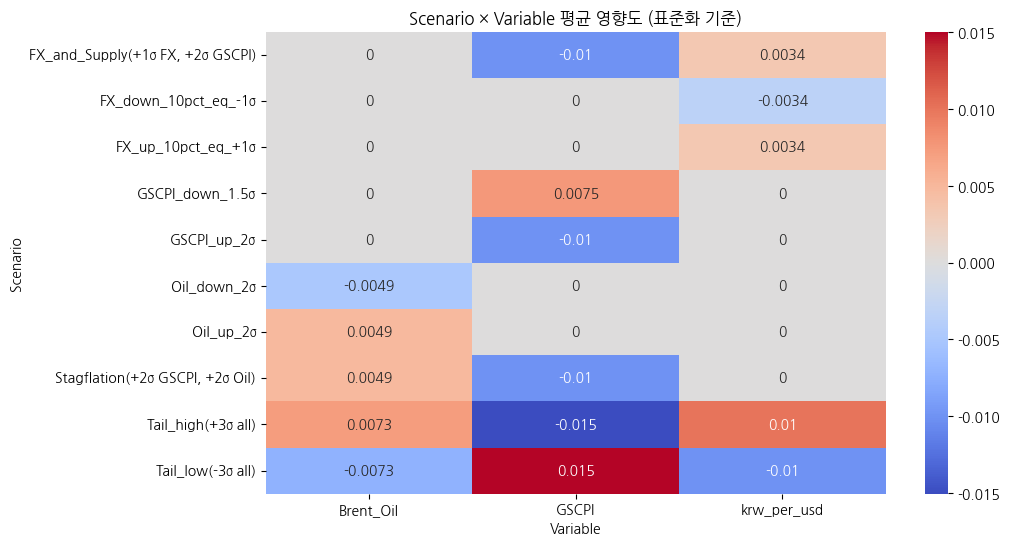

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시나리오-변수 pivot
pivot = (
    impact_df.groupby(["Scenario","variable"])["impact_rel"]
    .mean().unstack().fillna(0)
)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", center=0)
plt.title("Scenario × Variable 평균 영향도 (표준화 기준)")
plt.xlabel("Variable")
plt.ylabel("Scenario")
plt.show()

## 모델별 영향 TOP 10 바차트

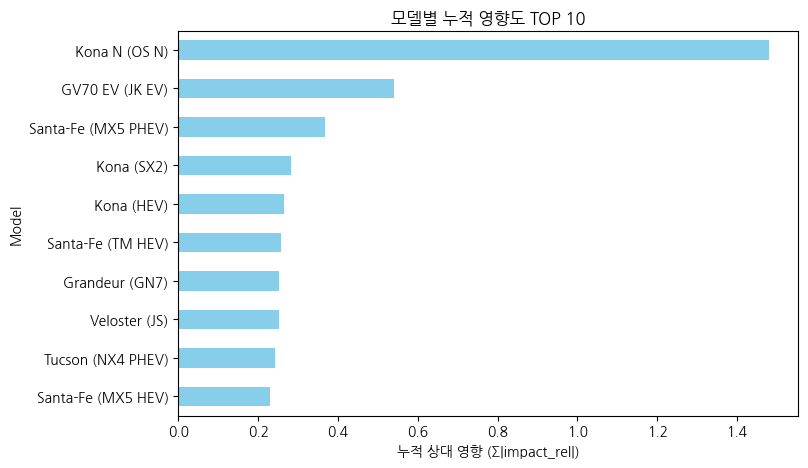

In [ ]:
top_models = (
    impact_df.groupby("Model")["impact_rel"]
    .sum().sort_values(ascending=False).head(10)
)

plt.figure(figsize=(8,5))
top_models.plot(kind="barh", color="skyblue")
plt.gca().invert_yaxis()
plt.title("모델별 누적 영향도 TOP 10")
plt.xlabel("누적 상대 영향 (Σ|impact_rel|)")
plt.show()

## 지역별 평균 영향 비교

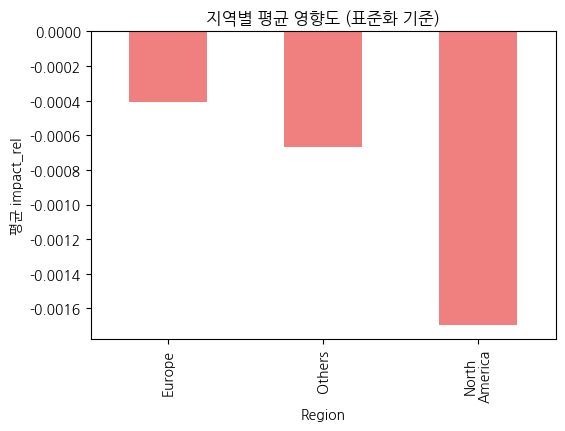

In [ ]:
region_mean = (
    impact_df.groupby("Region")["impact_rel"].mean().sort_values(ascending=False)
)

plt.figure(figsize=(6,4))
region_mean.plot(kind="bar", color="lightcoral")
plt.title("지역별 평균 영향도 (표준화 기준)")
plt.ylabel("평균 impact_rel")
plt.show()